# Importy, wizualizacja
(Należy odpalić i schować).

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.decomposition import PCA
from torch import nn
from torch.utils.data import Subset
from torchvision.datasets import MNIST, FashionMNIST
from torchvision.transforms import Compose, Lambda, ToTensor

%matplotlib inline


def plot_dataset(train_data, model):
    view_data = train_data.data[:5].view(-1, 28 * 28) / 255.0
    _, decoded_data = model.forward(train_data.data[:5].view(-1, 784).float().to("cpu") / 255.0)
    decoded_data = decoded_data.cpu().detach().numpy()

    n_rows = 2 if decoded_data is not None else 1
    n_cols = len(view_data)
    plt.suptitle("Reconstruction")
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))

    if decoded_data is not None:
        for i in range(n_cols):
            axes[0][i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap="gray")
            axes[0][i].set_xticks(())
            axes[0][i].set_yticks(())

        for i in range(n_cols):
            axes[1][i].clear()
            axes[1][i].imshow(np.reshape(decoded_data[i], (28, 28)), cmap="gray")
            axes[1][i].set_xticks(())
            axes[1][i].set_yticks(())

    else:
        for i in range(n_cols):
            axes[i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap="gray")
            axes[i].set_xticks(())
            axes[i].set_yticks(())

    plt.show()


def plot_pca(data, model):
    labels = data.classes
    plt.suptitle("Reduction of latent space")
    _ = plt.figure(figsize=(10, 6))
    pca = PCA(2)

    z = model.encode(train_data.data.view(-1, 784).float().to("cpu"))
    reduced_z = pca.fit_transform(z.detach().cpu().numpy())

    for class_idx in range(10):
        indices = data.targets == class_idx
        plt.scatter(reduced_z[indices, 0], reduced_z[indices, 1], s=2.0, label=labels[class_idx])

    plt.legend()
    plt.show()


torch.manual_seed(1337)
batch_size = 128
transforms = Compose([ToTensor(), Lambda(lambda x: x.flatten())])

# Mnist dataset
train_data = MNIST(
    root=".", train=True, transform=transforms, download=True
)  # change to false if you already have the data

# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

# Auoenkoder i modele generatywne

Na dzisiejszych zajęciach poznamy model autoenkodera i pokażemy, kolejno:
1. Jak jego ukrytą reprezentację można wykorzystać do uczenia częściowo nadzorowanego
2. Jak można wymusić na autoenkoderze generatywność i "zmusić" go do generowania nowych przykładów podobnych do tych ze zbioru treningowego.


## Podstawowy autoenkoder

![Auto-encoder](https://raw.githubusercontent.com/gmum/ml2023-24/master/lab/resources/ae.png)

Autoenkoder rozumiemy jako sieć neuronową, która na wyjściu ma odtwarzać ten sam obiekt, który dostaje na wejściu. Zazwyczaj na autoenkoder patrzymy jako na połączenie dwóch modeli: enkodera $\mathcal{E}$ i dekodera $\mathcal{D}$. Interpretujemy działanie modelu w następujący sposób: enkoder kompresuje wejściowy przykład $x$ do wektora $y$, o którym myślimy jako o reprezentacji ukrytej. Dekoder na podstawie wektora $y$ produkuje $\hat{x}$, które ma aproksymować oryginalne wejście $x$. Tzn.:

$$
y = \mathcal{E} x 
$$
$$
\hat{x} = \mathcal{D} y
$$

Funkcją kosztu w autoenkoderze będzie MSE pomiędzy wejściem a wyjściem:
$$
\mathcal{L}_{AE} =\frac{1}{n}\sum_i \|x_i-\mathcal{D}\mathcal{E} x_i\|_2^2,
$$
 

Enkoder i dekoder mogą być dowolnymi sieciami neuronowymi, najczęściej jednak dekoder składa się z tych samych transformacji co enkoder w odwrotnej kolejności.  

## Zadanie 1. Vanilla Autoencoder (1 pkt.)

Należy zaimplementować enkoder i dekoder. Kolejne warstwy w enkoderze mają mieć następującą liczbę neuronów: [784, 128, 128, 64, `latent_dim`]. Analogicznie dekoder ma wyglądać następująco: [`latent_dim`, 64, 128, 128, 784]. Wejście i wyjście mają 784 neurony, jako że taka jest wymiarowość MNIST-a. Wartość `latent_dim` dostajemy na wejściu do konstruktora (`latent_dim`).

Po warstwach ukrytych chcemy mieć aktywacje ReLU, **na końcu enkodera nie stosujemy żadnej aktywacji**, na końcu dekodera stosujemy aktywację sigmoidalną.

**Pytanie: Dlaczego na końcu dekodera chcemy mieć sigmoidę?**

In [53]:
# sigmoida zeby uzyskac wynik w przedziale [0;1]
class AutoEncoder(torch.nn.Module):
    def __init__(self, latent_dim: int):
        
        super(AutoEncoder, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = torch.nn.Sequential(
			    torch.nn.Linear(784, 128),
			    torch.nn.ReLU(),
          torch.nn.Linear(128, 128),
			    torch.nn.ReLU(),
			    torch.nn.Linear(128, 64),
			    torch.nn.ReLU(),
			    torch.nn.Linear(64, self.latent_dim)
		    )
        self.decoder = torch.nn.Sequential(
			    torch.nn.Linear(self.latent_dim, 64),
			    torch.nn.ReLU(),
			    torch.nn.Linear(64, 128),
			    torch.nn.ReLU(),
			    torch.nn.Linear(128, 128),
			    torch.nn.ReLU(),
			    torch.nn.Linear(128, 784),
			    torch.nn.Sigmoid()
		    )
        
    def decode(self, encoded: torch.Tensor):
        return self.decoder(encoded)
    
    def encode(self, x: torch.Tensor):
        return self.encoder(x)

    def forward(self, x: torch.Tensor):
        # encode and decode
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return encoded, decoded

Epoch: 0  |  train loss: 0.0507


<Figure size 640x480 with 0 Axes>

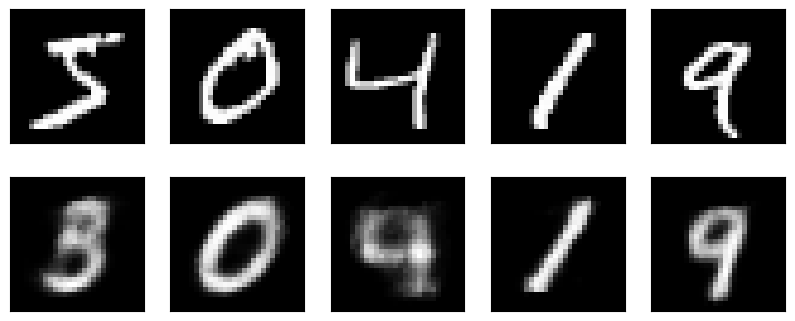

<Figure size 640x480 with 0 Axes>

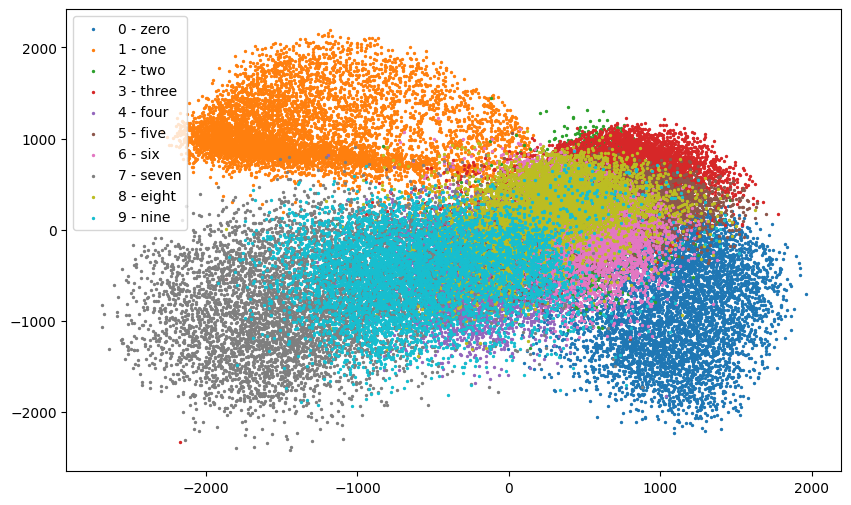

Epoch: 1  |  train loss: 0.0300
Epoch: 2  |  train loss: 0.0246
Epoch: 3  |  train loss: 0.0216
Epoch: 4  |  train loss: 0.0199
Epoch: 5  |  train loss: 0.0187
Epoch: 6  |  train loss: 0.0180
Epoch: 7  |  train loss: 0.0175
Epoch: 8  |  train loss: 0.0171
Epoch: 9  |  train loss: 0.0168
Epoch: 10  |  train loss: 0.0166


<Figure size 640x480 with 0 Axes>

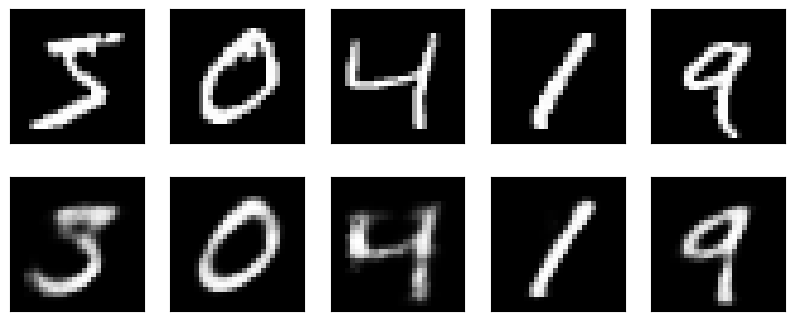

<Figure size 640x480 with 0 Axes>

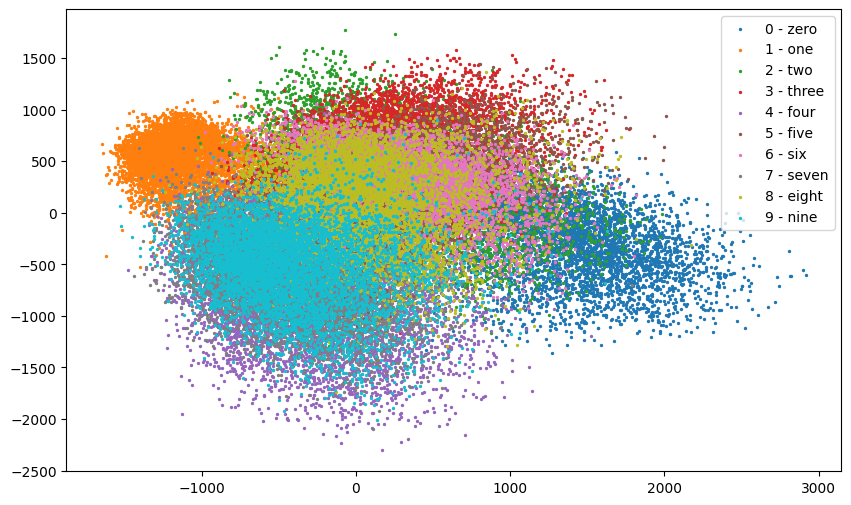

Epoch: 11  |  train loss: 0.0164
Epoch: 12  |  train loss: 0.0162
Epoch: 13  |  train loss: 0.0161
Epoch: 14  |  train loss: 0.0160
Epoch: 15  |  train loss: 0.0158
Epoch: 16  |  train loss: 0.0158
Epoch: 17  |  train loss: 0.0157
Epoch: 18  |  train loss: 0.0156
Epoch: 19  |  train loss: 0.0155
Epoch: 20  |  train loss: 0.0155


<Figure size 640x480 with 0 Axes>

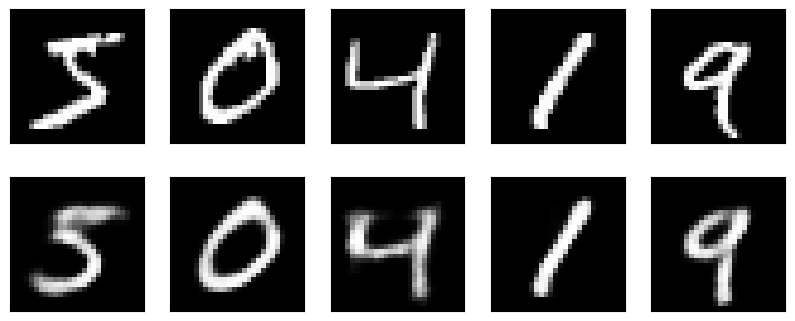

<Figure size 640x480 with 0 Axes>

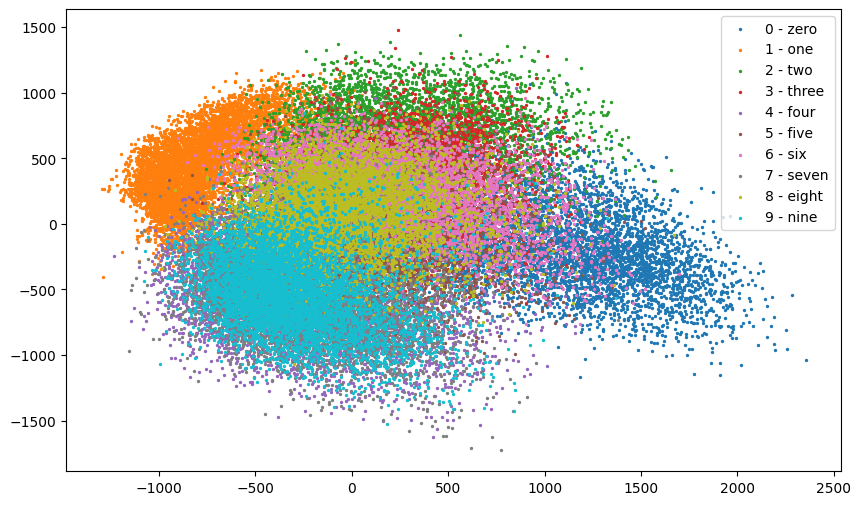

Epoch: 21  |  train loss: 0.0154
Epoch: 22  |  train loss: 0.0153
Epoch: 23  |  train loss: 0.0153
Epoch: 24  |  train loss: 0.0152


In [54]:
# Hyper Parameters
epochs: int = 25
LR: float = 5e-3  # learning rate

# prepare original data for plotting

autoencoder = AutoEncoder(latent_dim=10).to("cpu")

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
rec_loss_fn = torch.nn.MSELoss()

for epoch in range(epochs):
    epoch_losses = []  # For logging purposes
    for step, (x, y) in enumerate(train_loader):
        x = x.to("cpu")
        encoded, decoded = autoencoder(x)
        loss_val = rec_loss_fn(decoded, x)  # calculate loss
        optimizer.zero_grad()  # clear gradients for this training step
        loss_val.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients

        epoch_losses.append(loss_val.item())

    print(f"Epoch: {epoch}  |  train loss: {np.mean(epoch_losses):.4f}")

    if epoch % 10 == 0:
        plot_dataset(train_data, autoencoder)
        plot_pca(train_data, autoencoder)

## Część 1: Uczenie częściowo nadzorowane (semi-supervised learning)

W praktyce zbudowanie w pełni nadzorowanego zbioru danych często jest kosztowne. Jeżeli chcielibyśmy uczyć się klasyfikacji obrazków naturalnych, to zdobycie dużych zbiorów danych nie jest trudne (możemy je zescrapować z internetu), natomiast zdobycie do nich etykiet wymagałoby czasu człowieka, który zidentyfikowałby, co się znajduje na poszczególnych obrazkach. W niektórych przypadkach etykietowanie jest jeszcze bardziej kosztowne - w zagadnieniu segmentacji, gdzie chcemy każdemu pikselowi w obrazku przypisać jedną klasę, zapisanie etykiety dla jednego obrazka może zająć ekspertowi kilka godzin.

Problem liczby etykiet i ich jakości jest w praktyce bardzo istotny. Dlatego też w praktyce chcielibyśmy mieć metody głębokiego uczenia, które potrafią wykorzystać dane, dla których nie mamy etykiet. W poniższym przykładzie zbudujemy prosty model częściowo nadzorowany z wykorzystaniem autoenkodera.


## Zadanie 2. Uczenie częściowo nadzorowane (3 pkt.)

Załóżmy, że z 60.000 przykładów zbiorze MNIST tylko 100 przykładów ma podaną etykietę, a dla pozostałych 59.900 nie mamy etykiety - tym samym mamy problem uczenia częściowo nadzorowanego. Nasze 100 przykładów z etykietami zdefiniowane są w zmiennej `labeled_data`.

1. Zaimplementuj i wytrenuj sieć neuronową (klasyfikator), która uczy się wyłącznie bezpośrednio na 100 podanych przykładach. Po **wytrenowaniu wypisz accuracy na zbiorze testowym, jaki udało Ci się uzyskać**. Sieć powinna być względnie mała (max 4 warstwy, max 128 neuronów w warstwie). Zapisz wynik.
2. Zaimplementuj i wytrenuj sieć neuronową (klasyfikator) o podobnej architekturze co w poprzednim punkcie, również na datasecie 100 przykładów, ale tym razem niech wejściem do sieci będzie ukryta reprezentacja $y = \mathcal{E}x$ stworzona przez autoenkoder wytrenowany w Zadaniu 1. Zapisz wynik.
3. Porównaj wyniki obu modeli. Wskaż, który nauczył się lepiej i podaj hipotezę dlaczego.


In [55]:
labeled_data = Subset(train_data, range(100))
labeled_loader = torch.utils.data.DataLoader(dataset=labeled_data, batch_size=32, shuffle=True)

test_data = MNIST(
    root=".", train=False, transform=transforms, download=True
)  # change to false if you already have the data
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=5000, shuffle=True)

In [58]:
### Tutaj zaimplementuj i wytrenuj model baseline'owy
from typing import List
from torch import nn
from torch.optim import SGD
from torch.nn.functional import cross_entropy


class CustomNetwork(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):
        super(CustomNetwork, self).__init__()

        self.w1 = nn.Parameter(torch.nn.init.xavier_normal_(torch.empty(input_dim, hidden_dim)))
        self.b1 = nn.Parameter(torch.zeros(hidden_dim))
        self.w2 = nn.Parameter(torch.nn.init.xavier_normal_(torch.empty(hidden_dim, output_dim)))
        self.b2 = nn.Parameter(torch.zeros(output_dim))

        self.batch_norm = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = torch.tanh(x @ self.w1 + self.b1)
        x = self.batch_norm(x)
        x = self.dropout(x)
        x = x @ self.w2 + self.b2
        return x

    def parameters(self) -> List[torch.Tensor]:
        return [self.w1, self.b1, self.w2, self.b2]

batch_size = 128
epochs = 50

model = CustomNetwork(784, 64, 10)
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.8, weight_decay=1e-4)
loss_fun = nn.CrossEntropyLoss()

# training loop
for epoch in range(epochs):
    model.train()
    for i, (data, expectedOut) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fun(output, expectedOut)
        loss.backward()
        optimizer.step()

    # evaluation on the test set
    model.eval()
    with torch.no_grad():
        correct_count = 0
        for i, (data, expectedOut) in enumerate(test_loader):
            output: torch.Tensor = model(data)
            correct_count += (output.argmax(1) == expectedOut).sum().item()
    accuracy = correct_count / len(test_data)
    print(f"Epoch {epoch + 1}/{epochs}, Test Accuracy: {accuracy:.4f}")

print(f"\nTest accuracy: {correct_count / len(test_data)}")


Epoch 1/50, Test Accuracy: 0.8672
Epoch 2/50, Test Accuracy: 0.8924
Epoch 3/50, Test Accuracy: 0.8991
Epoch 4/50, Test Accuracy: 0.9048
Epoch 5/50, Test Accuracy: 0.9096
Epoch 6/50, Test Accuracy: 0.9121
Epoch 7/50, Test Accuracy: 0.9134
Epoch 8/50, Test Accuracy: 0.9162
Epoch 9/50, Test Accuracy: 0.9169
Epoch 10/50, Test Accuracy: 0.9183
Epoch 11/50, Test Accuracy: 0.9181
Epoch 12/50, Test Accuracy: 0.9204
Epoch 13/50, Test Accuracy: 0.9212
Epoch 14/50, Test Accuracy: 0.9231
Epoch 15/50, Test Accuracy: 0.9233
Epoch 16/50, Test Accuracy: 0.9256
Epoch 17/50, Test Accuracy: 0.9265
Epoch 18/50, Test Accuracy: 0.9269
Epoch 19/50, Test Accuracy: 0.9274
Epoch 20/50, Test Accuracy: 0.9282
Epoch 21/50, Test Accuracy: 0.9284
Epoch 22/50, Test Accuracy: 0.9292
Epoch 23/50, Test Accuracy: 0.9294
Epoch 24/50, Test Accuracy: 0.9297
Epoch 25/50, Test Accuracy: 0.9313
Epoch 26/50, Test Accuracy: 0.9320
Epoch 27/50, Test Accuracy: 0.9329
Epoch 28/50, Test Accuracy: 0.9332
Epoch 29/50, Test Accuracy: 0

In [60]:
### Tutaj zaimplementuj i wytrenuj klasyfikator oparty o reprezentację podaną przez autoenkoder.

class CustomNetwork(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(CustomNetwork, self).__init__()

        self.w1 = nn.Parameter(torch.nn.init.xavier_normal_(torch.empty(input_dim, hidden_dim)))
        self.b1 = nn.Parameter(torch.zeros(hidden_dim))
        self.w2 = nn.Parameter(torch.nn.init.xavier_normal_(torch.empty(hidden_dim, output_dim)))
        self.b2 = nn.Parameter(torch.zeros(output_dim))

        self.batch_norm = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(0.2)

    def __call__(self, x):
        x = torch.tanh(x @ self.w1 + self.b1)
        x = self.batch_norm(x)
        x = self.dropout(x)
        x = x @ self.w2 + self.b2
        return x

    def parameters(self) -> List[torch.Tensor]:
        return [self.w1, self.b1, self.w2, self.b2]


batch_size = 64
epochs = 50
model = CustomNetwork(10, 64, 10)
optimizer: torch.optim.Optimizer = SGD(model.parameters(), lr= 0.001, momentum=0.8)
lossFun = nn.CrossEntropyLoss()


# training loop
for epoch in range(epochs):
    model.train()
    for i, (data, expectedOut) in enumerate(train_loader):
        optimizer.zero_grad()
        enc = autoencoder.encode(data.to('cpu'))
        output = model(enc.to('cpu'))
        loss = lossFun(output, expectedOut)
        loss.backward()
        optimizer.step()

    model.eval()
    correct_count = 0
    with torch.no_grad():
        for i, (data, expectedOut) in enumerate(test_loader):
            enc = autoencoder.encode(data.to('cpu'))
            output = model(enc.to('cpu'))
            correct_count += (output.argmax(1) == expectedOut).float().sum().item()
    accuracy = correct_count / len(test_data)
    print(f"Epoch {epoch + 1}/{epochs}, Test Accuracy: {accuracy:.4f}")

print(f"\nTest accuracy: {correct_count / len(test_data)}")

Epoch 1/50, Test Accuracy: 0.8767
Epoch 2/50, Test Accuracy: 0.8954
Epoch 3/50, Test Accuracy: 0.9029
Epoch 4/50, Test Accuracy: 0.9056
Epoch 5/50, Test Accuracy: 0.9070
Epoch 6/50, Test Accuracy: 0.9086
Epoch 7/50, Test Accuracy: 0.9096
Epoch 8/50, Test Accuracy: 0.9102
Epoch 9/50, Test Accuracy: 0.9119
Epoch 10/50, Test Accuracy: 0.9135
Epoch 11/50, Test Accuracy: 0.9144
Epoch 12/50, Test Accuracy: 0.9147
Epoch 13/50, Test Accuracy: 0.9169
Epoch 14/50, Test Accuracy: 0.9178
Epoch 15/50, Test Accuracy: 0.9185
Epoch 16/50, Test Accuracy: 0.9196
Epoch 17/50, Test Accuracy: 0.9211
Epoch 18/50, Test Accuracy: 0.9209
Epoch 19/50, Test Accuracy: 0.9215
Epoch 20/50, Test Accuracy: 0.9232
Epoch 21/50, Test Accuracy: 0.9237
Epoch 22/50, Test Accuracy: 0.9242
Epoch 23/50, Test Accuracy: 0.9254
Epoch 24/50, Test Accuracy: 0.9251
Epoch 25/50, Test Accuracy: 0.9256
Epoch 26/50, Test Accuracy: 0.9270
Epoch 27/50, Test Accuracy: 0.9270
Epoch 28/50, Test Accuracy: 0.9273
Epoch 29/50, Test Accuracy: 0

## Dygresja: Inne zagadnienia uczenia ze słabym nadzorem
Podany powyżej przykład jest bardzo prostym podejściem do problemu uczenia danych ze słabym nadzorem. Dla zainteresowanych trochę więcej materiałów:

* [Praca przeglądowa o problemie słabego nadzoru](https://academic.oup.com/nsr/article-pdf/5/1/44/31567770/nwx106.pdf)
* [Pseudo-labeling do uczenia częściowo nazdorowanego](https://github.com/emintham/Papers/blob/master/Lee-%20Pseudo-Label:%20The%20Simple%20and%20Efficient%20Semi-Supervised%20Learning%20Method%20for%20Deep%20Neural%20Networks.pdf) - W tym podejściu do uczenia częściowo nadzorowanego trenujemy model na poetykietowanych danych, używamy jego predykcji żeby poetykietować resztę danych i uczymy model z takimi (narzuconymi przez siebie) etykietami. Wbrew intuicji to podejście dziala całkiem dobrze.
* [Przegląd metod self-supervision](https://lilianweng.github.io/lil-log/2019/11/10/self-supervised-learning.html) - Czy możemy się uczyć z danych na podstawie łatwych do otrzymania etykiet (np. o ile stopni zdjęcie zostało obrócone)?
* [Przegląd metod kontrastywnych](https://arxiv.org/abs/2011.00362) - Czy możemy się uczyć reprezentacji na podstawie szukania podobieństw między przykładami?

# Część 2: Modele generatywne

Interesującym zastosowaniem sieci neuronowych jest generowanie nowych przykładów ze zbioru treningowego, np. [generowanie nowych twarzy](https://thispersondoesnotexist.com/) albo [generowanie tekstu](https://transformer.huggingface.co/doc/gpt2-large). Na dzisiejszych zajęciach spróbujemy zbudować prosty model generatywny oparty o autoenkoder.

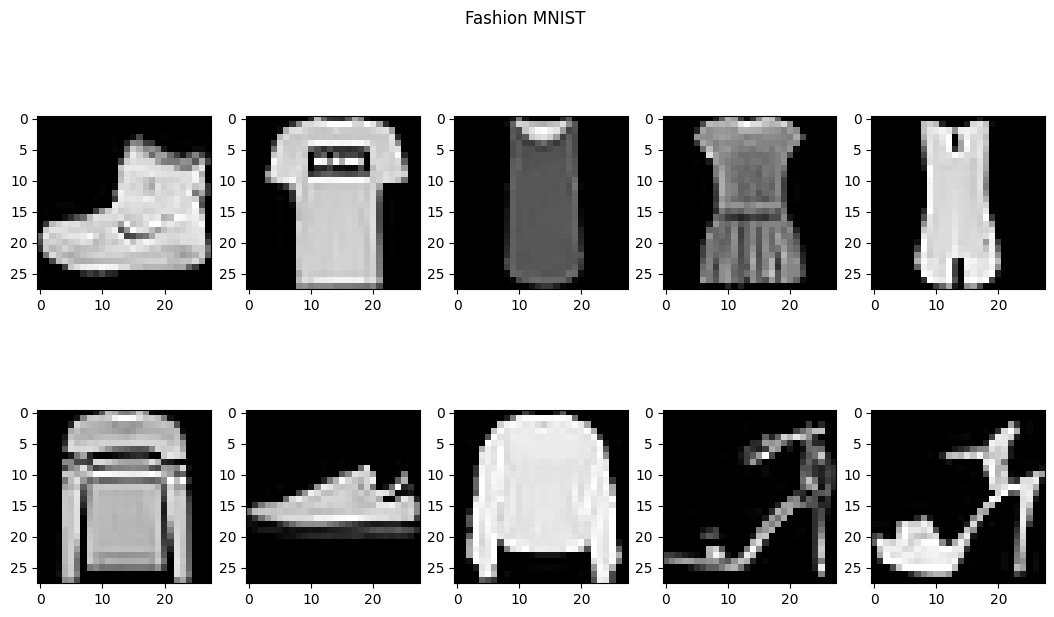

In [61]:
# FashionMNIST dataset
transforms = Compose([ToTensor(), Lambda(lambda x: x.flatten())])
train_data = FashionMNIST(root=".", train=True, transform=transforms, download=True)

batch_size = 256
# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

_, axes = plt.subplots(2, 5, figsize=(13, 7))
for im, ax in zip(train_data.data[:10], axes.reshape(-1)):
    ax.imshow(im, cmap="gray")
plt.suptitle("Fashion MNIST")
plt.show()


## Zadanie 3: WAE-MMD (3 pkt.)
W ramach zadania należy:
1. Zaimplementować architekturę autoenkodera (enkoder + dekoder), podobną do tej zaprezentowanej w Zadaniu 1. Jako że dataset FMNIST jest trudniejszy, to architektura też powinna być istotnie większa (np. 50 wymiarów przestrzeni ukrytej).
2. Zaimplementować pętlę uczenia WAE, w której minimalizujemy koszt $\mathcal{L}_{WAE-MMD}$.
3. Dostosować hiperparametry (learning rate, liczba epok, $C$, $\sigma$, etc.), tak żeby rekonstrukcja i generowane sample wyglądały na poziomie porównywalnym do tych pokazanych poniżej (albo lepiej). Zacznij od $C=1$, $\sigma = 2D$, gdzie $D$ to wymiar przestrzeni ukrytej.

W razie potrzeby można wspomóc się materiałami z wykładu, [oryginalną pracą o autoenkoderze Wassersteina](https://arxiv.org/abs/1711.01558) (interesuje nas zwłaszcza strona piąta, Algorytm 2 WAE-MMD) oraz [oficjalnie dostępną implementacją](https://github.com/tolstikhin/wae). 



In [62]:
class WAEMMD(nn.Module):
    
    def __init__(self, latent_dim: int):
        
        super(WAEMMD, self).__init__()
        
        self.latent_dim = latent_dim
        self.encoder = torch.nn.Sequential(
			    torch.nn.Linear(784, 128),
			    torch.nn.ReLU(),
          torch.nn.Linear(128, 128),
			    torch.nn.ReLU(),
			    torch.nn.Linear(128, 64),
			    torch.nn.ReLU(),
			    torch.nn.Linear(64, self.latent_dim)
		    )
        self.decoder = torch.nn.Sequential(
			    torch.nn.Linear(self.latent_dim, 64),
			    torch.nn.ReLU(),
			    torch.nn.Linear(64, 128),
			    torch.nn.ReLU(),
			    torch.nn.Linear(128, 128),
			    torch.nn.ReLU(),
			    torch.nn.Linear(128, 784),
			    torch.nn.Sigmoid()
		    )
        
    def decode(self, encoded: torch.Tensor):
        return self.decoder(encoded)
    
    def encode(self, x: torch.Tensor):
        return self.encoder(x)

    def forward(self, x: torch.Tensor):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return encoded, decoded
    
    def gaussian_kernel(self,y,z, sigma):
      return sigma / ( sigma + torch.absolute(y-z) ** 2 )

    def avg_gaussian_kernel(self,a,b, sigma):
      ans = self.gaussian_kernel(a[0], b[0], sigma)
      return torch.mean(ans)
    
    def mmd_loss(self, y: torch.Tensor, sigma: float):
        z = torch.randn(20, self.latent_dim).to("cpu")
        return self.avg_gaussian_kernel(y,y, sigma) + self.avg_gaussian_kernel(z,z, sigma) - 2 * self.avg_gaussian_kernel(y,z, sigma)

<Figure size 640x480 with 0 Axes>

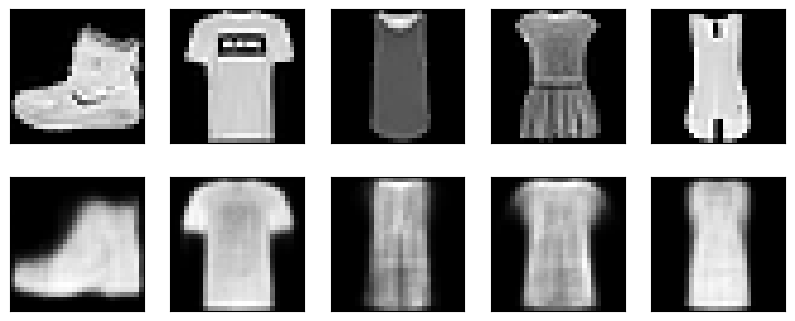

<Figure size 640x480 with 0 Axes>

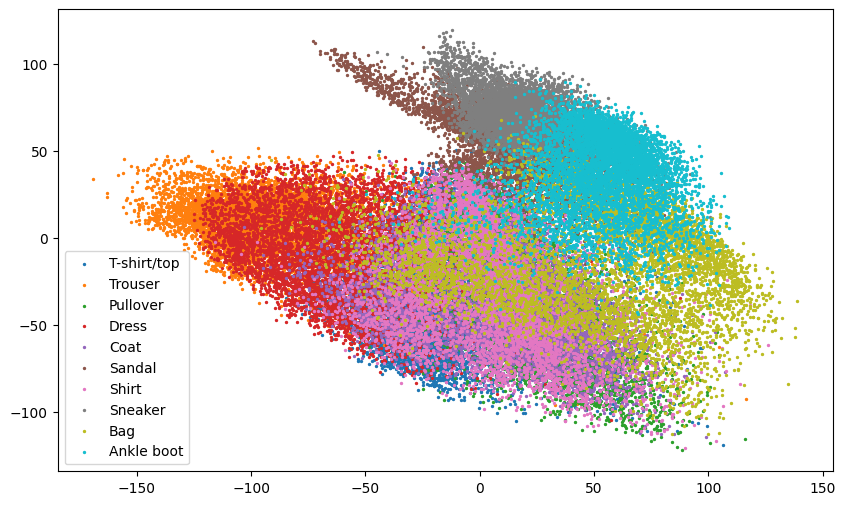

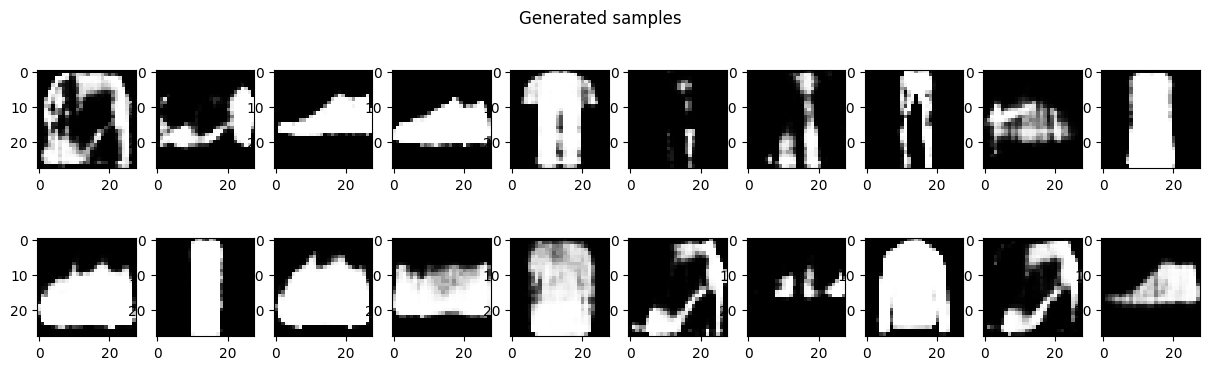

Epoch: 10, train loss: 0.0278


<Figure size 640x480 with 0 Axes>

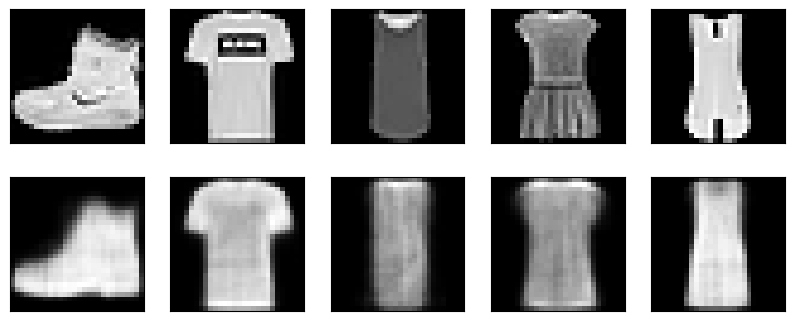

<Figure size 640x480 with 0 Axes>

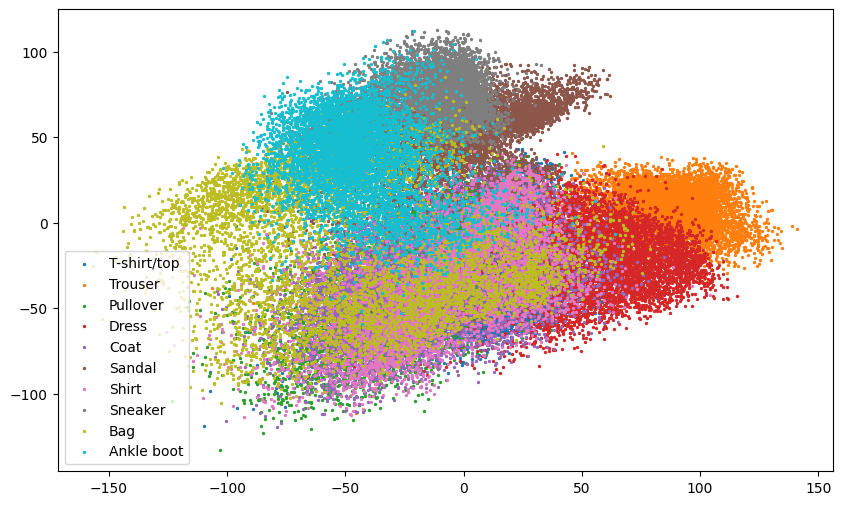

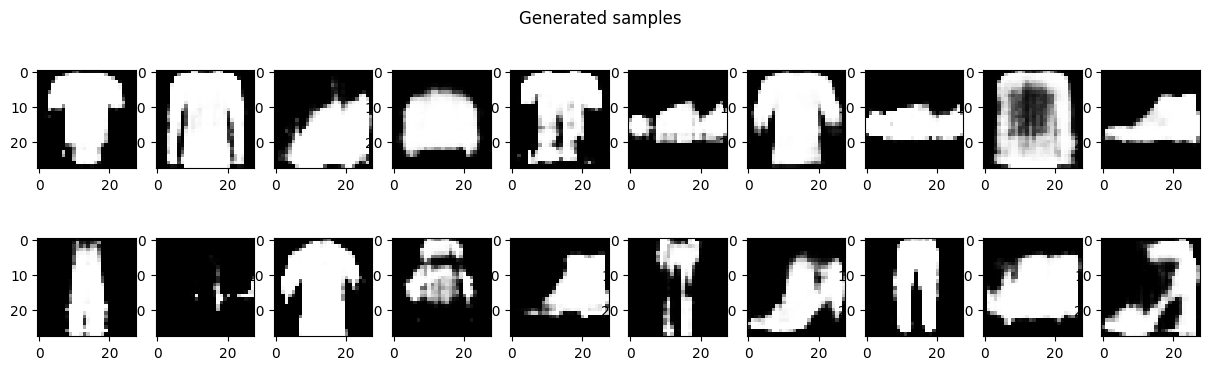

Epoch: 20, train loss: 0.0257


<Figure size 640x480 with 0 Axes>

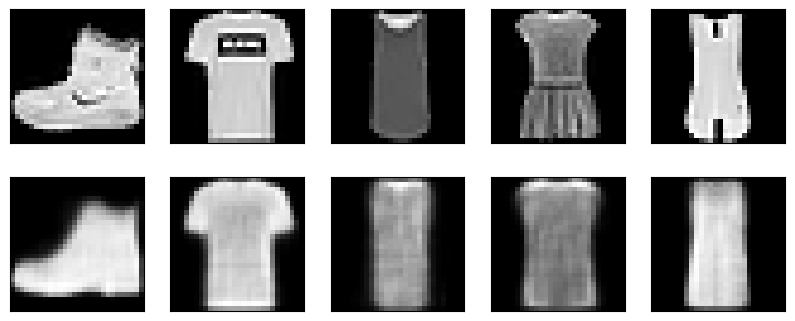

<Figure size 640x480 with 0 Axes>

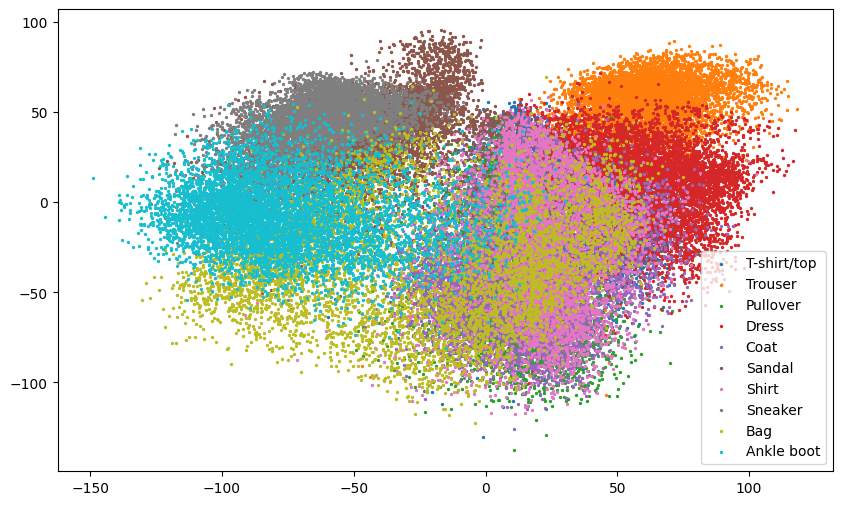

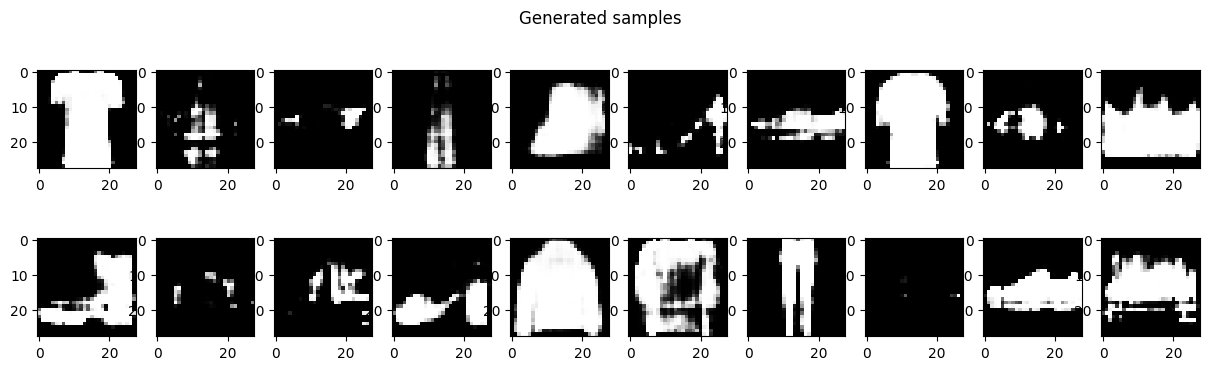

Epoch: 30, train loss: 0.0244


<Figure size 640x480 with 0 Axes>

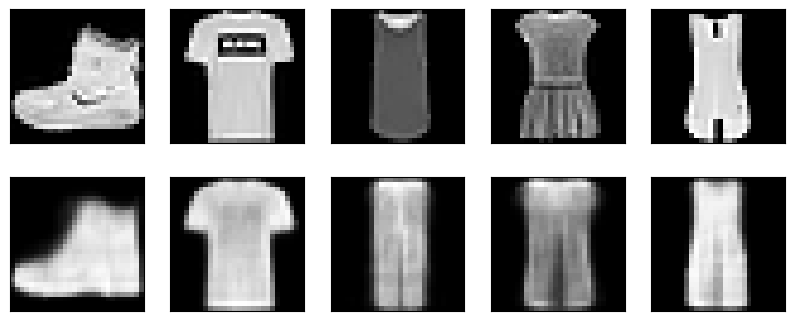

<Figure size 640x480 with 0 Axes>

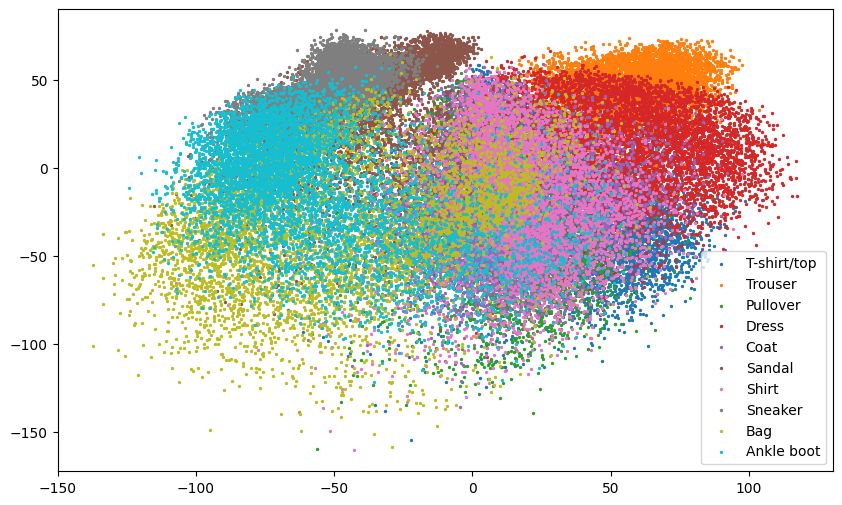

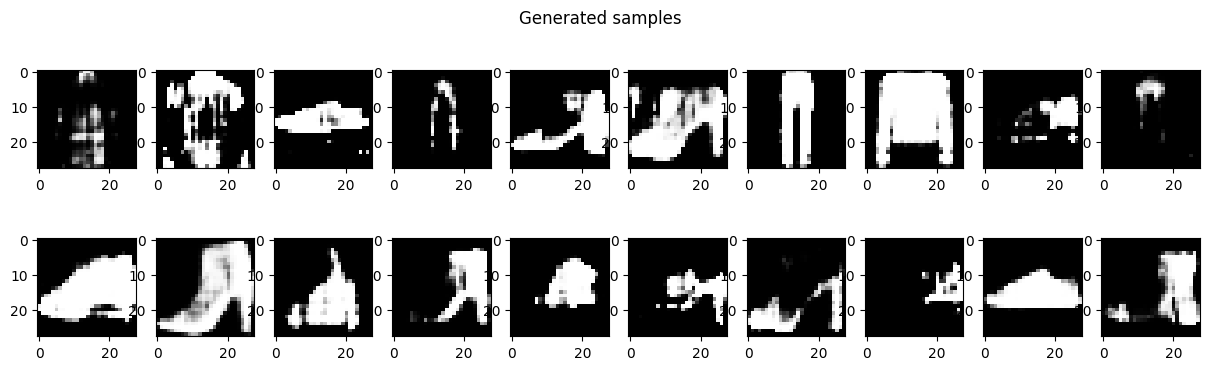

Epoch: 40, train loss: 0.0242


<Figure size 640x480 with 0 Axes>

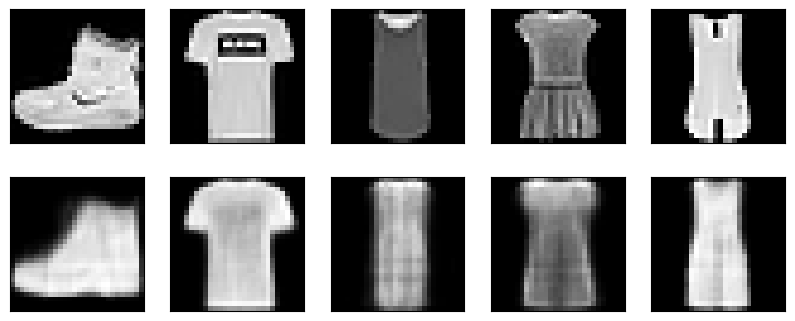

<Figure size 640x480 with 0 Axes>

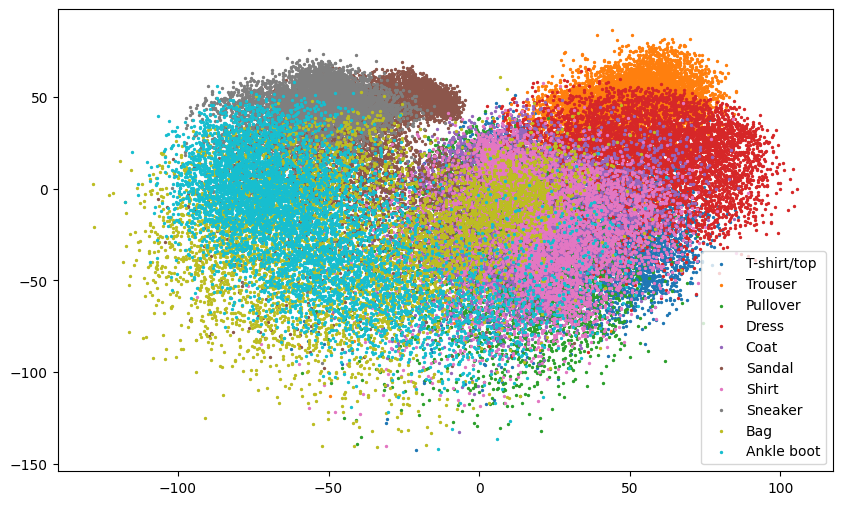

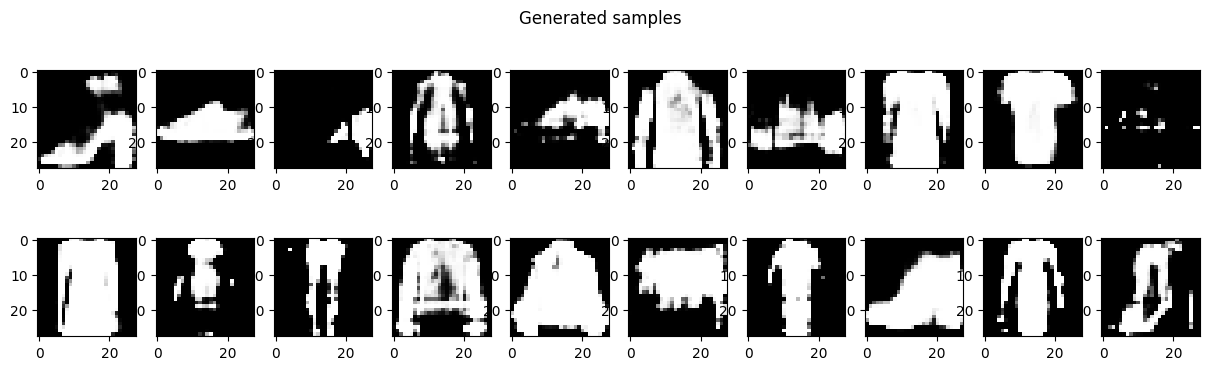

Epoch: 50, train loss: 0.0236


<Figure size 640x480 with 0 Axes>

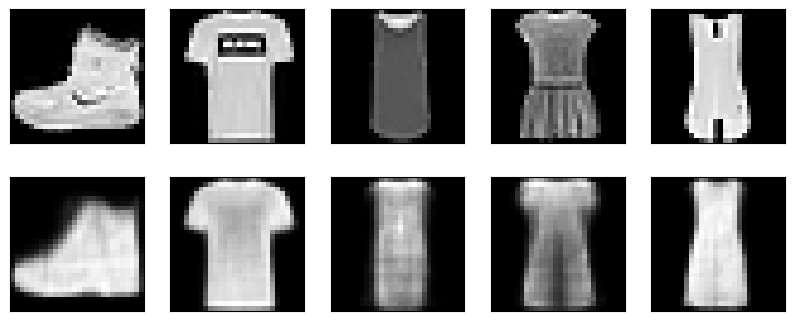

<Figure size 640x480 with 0 Axes>

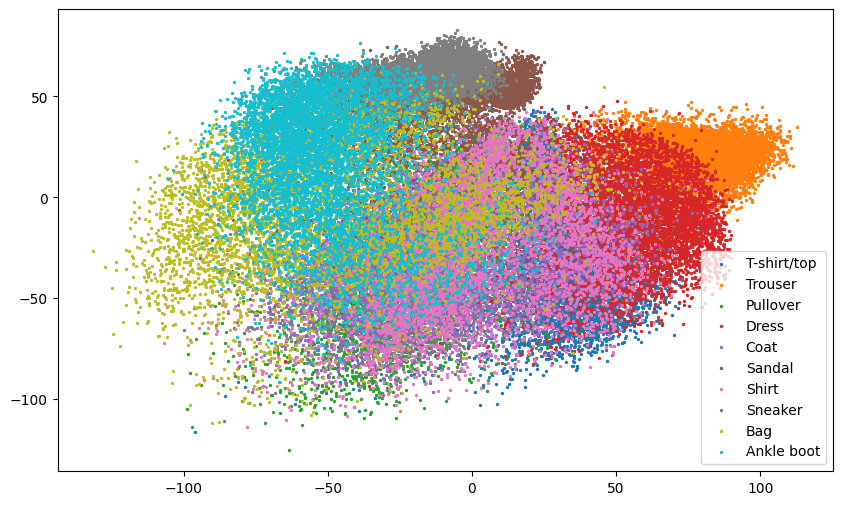

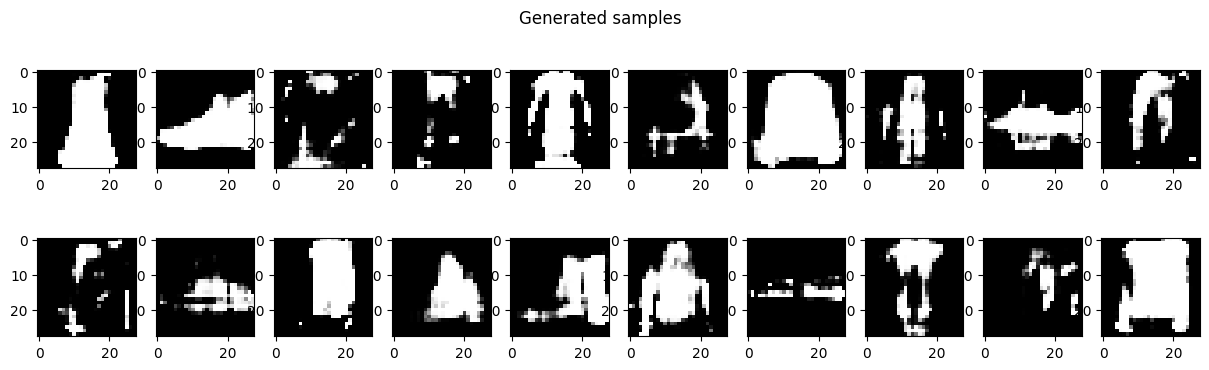

Epoch: 60, train loss: 0.0230


<Figure size 640x480 with 0 Axes>

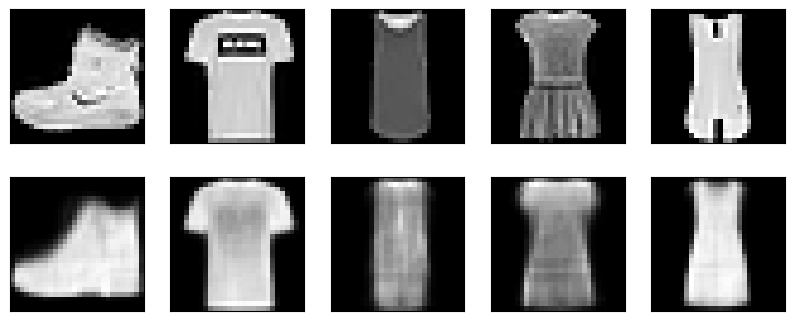

<Figure size 640x480 with 0 Axes>

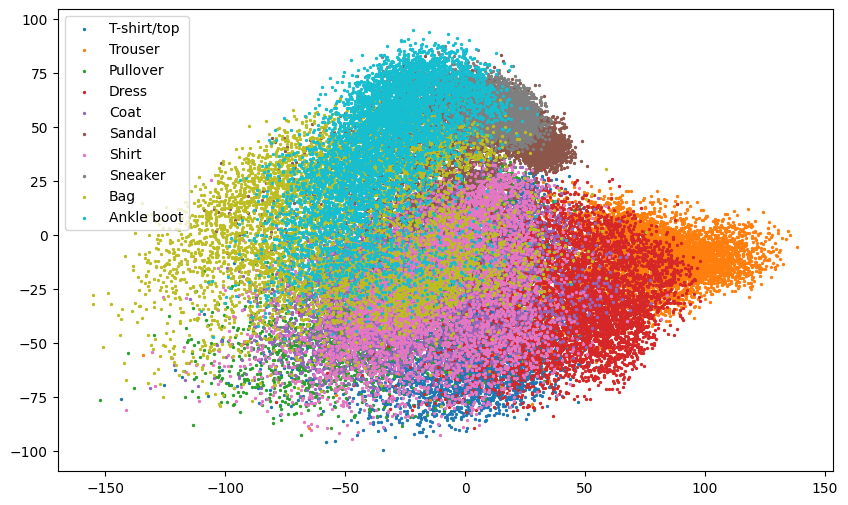

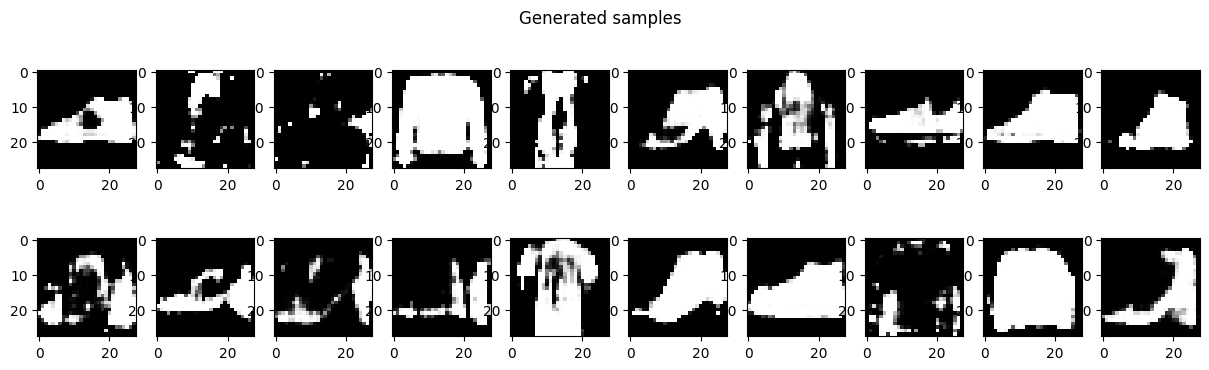

Epoch: 70, train loss: 0.0230


<Figure size 640x480 with 0 Axes>

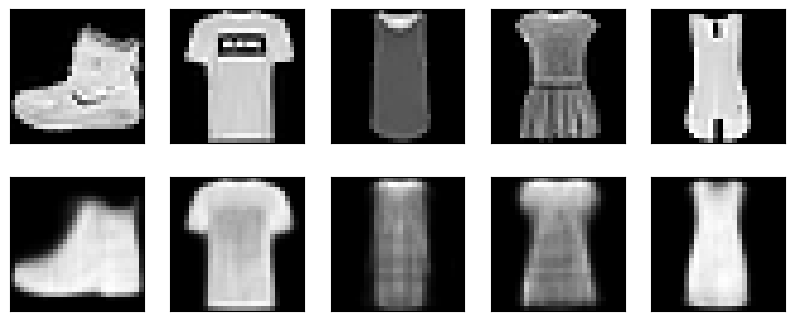

<Figure size 640x480 with 0 Axes>

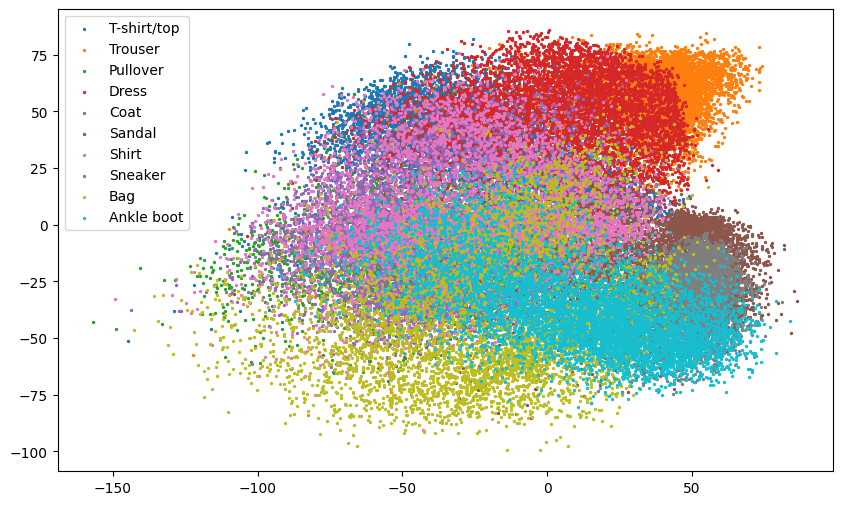

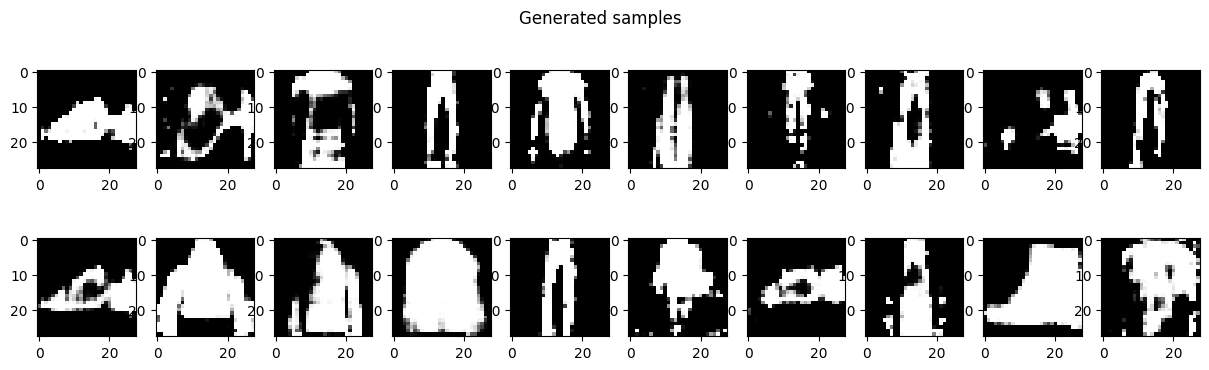

Epoch: 80, train loss: 0.0225


In [63]:
def plot_samples(model):
    # Important part - sampling from normal distribution and passing the results through the decoder.
    sampled_z = torch.randn(20, model.latent_dim).to("cpu")
    generated = model.decode(sampled_z)

    # Plotting the results
    generated = generated.cpu().detach().numpy()
    _, axes = plt.subplots(2, 10, figsize=(15, 4))
    for gen_im, ax in zip(generated, axes.reshape(-1)):
        ax.imshow(gen_im.reshape(28, 28), cmap="gray")
    plt.suptitle("Generated samples")
    plt.show()

sigma: float = 2*128
C: float = 1
epochs: int = 80

lr = 5e-3
wae = WAEMMD(latent_dim=10).to("cpu")
optimizer = torch.optim.Adam(wae.parameters(), lr=lr)
lossFun = torch.nn.MSELoss()

for epoch in range(1, epochs+1):
    losses = []
    for i, (x, y) in enumerate(train_loader):
        x = x.to("cpu")
        encoded, decoded = wae(x)
        loss = lossFun(decoded, x) + C * wae.mmd_loss(encoded, sigma)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    if epoch % 10 == 0:
        plot_dataset(train_data, wae)
        plot_pca(train_data, wae)
        plot_samples(wae)
        print(f'Epoch: {epoch}, train loss: {np.mean(losses):.4f}')

## Więcej materiałów o modelach generatywnych

* [Wykład o uczeniu nienadzorowanym i VAE](https://www.youtube.com/watch?v=f0s-uvvXvWg&list=PLqYmG7hTraZCDxZ44o4p3N5Anz3lLRVZF&index=10) - Interesujący wykład badaczy z DeepMindu zagłebiający się w to, dlaczego nienadzorowane uczenie się reprezentacji jest cenne i jak wykorzystać do tego VAE (model podobny do WAE). Polecamy też pozostałe wykłady z serii.
* [Cramer-Wold Autoencoder](https://arxiv.org/abs/1805.09235) - jak zaimplementować koszt WAE-MMD bez potrzeby samplowania w przestrzeni ukrytej?
